<a href="https://colab.research.google.com/github/ngarciap/AnalisisExploratorioDeDatos/blob/main/An%C3%A1lisis_Bivariado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Análisis Bivariado con Dataset de Prescripciones del mercado**
***Análisis Bivariado / Asociado a mi pregunta SMART***

In [ ]:
# Importar librerias
import pandas as pd
import numpy as np
import os

# Matplotlib y  seaborn para gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['figure.dpi'] = 200

#from google.colab import drive

""" Cargar Dataframes desde Google Drive
drive.mount('/content/drive', force_remount=True)
df_category = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Analisis Exploratorio de Datos/Bases/Market COL Jun/Category.xlsx', engine='openpyxl', dtype=str)
df_producto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Analisis Exploratorio de Datos/Bases/Market COL Jun/CUP_PRODUTO.TXT', sep='	', encoding='latin1', dtype=str)
df_molecula = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Analisis Exploratorio de Datos/Bases/Market COL Jun/CUP_MOLECULA.TXT', sep='	', encoding='latin1', dtype=str)
df_laboratorio = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Analisis Exploratorio de Datos/Bases/Market COL Jun/CUP_LABORATORIO.TXT', sep='	', encoding='latin1', dtype=str)
df_concentracion = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Analisis Exploratorio de Datos/Bases/Market COL Jun/CUP_CONCENTRACAO.TXT', sep='	', encoding='latin1', dtype=str)
df_prescripciones = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Analisis Exploratorio de Datos/Bases/Market COL Jun/CUP_FATO.TXT', sep='	', encoding='latin1', dtype=str)

"""
# Cargar Dataframes desde máquina local
df_category = pd.read_excel(os.path.join(os.getcwd() + "\Bases", "Category.xlsx"), engine='openpyxl', dtype=str)
df_clase = pd.read_csv(os.path.join(os.getcwd() + "\Bases", "CUP_CLASSE.TXT"), sep='	', encoding='latin1', dtype=str)
df_producto = pd.read_csv(os.path.join(os.getcwd() + "\Bases", "CUP_PRODUTO.TXT"), sep='	', encoding='latin1', dtype=str)
df_molecula = pd.read_csv(os.path.join(os.getcwd() + "\Bases", "CUP_MOLECULA.TXT"), sep='	', encoding='latin1', dtype=str)
df_laboratorio = pd.read_csv(os.path.join(os.getcwd() + "\Bases", "CUP_LABORATORIO.TXT"), sep='	', encoding='latin1', dtype=str)
df_concentracion = pd.read_csv(os.path.join(os.getcwd() + "\Bases", "CUP_CONCENTRACAO.TXT"), sep='	', encoding='latin1', dtype=str)
df_prescripciones = pd.read_csv(os.path.join(os.getcwd() + "\Bases", "CUP_FATO.TXT"), sep='	', encoding='latin1', dtype=str)


**Se realiza un alistamiento y transformación de los archivos cargados para poder analizar múltiples variables en el periodo de tiempo indicado en mi pregunta SMART**

In [ ]:
# Alistamiento de tabla de productos para cruzar con todos los atributos y dejarlos en un único dataframe
cols_producto = ['PRO_ID', 'NOMB_PRODUCT', 'MARCA_ID', 'NOMB_MARCA', 'CON_ID', 'CON_DESC', 'MOL_ID', 'MOL_DESC', 'CT4_ID', 'CT4_DESC', 'LAB_ID', 'LAB_DESC']
df_producto['CTIV_ID'] = df_producto['CTIV_ID'].str.pad(width=5, side='right', fillchar='0')
df_producto_completo = pd.merge(df_producto, df_clase, how='inner', left_on='CTIV_ID', right_on='CT4_ID')
df_producto_completo = pd.merge(df_producto_completo, df_laboratorio, how='inner', left_on='PRO_LAB_ID', right_on='LAB_ID')
df_producto_completo = pd.merge(df_producto_completo, df_molecula, how='inner', on='MOL_ID')
df_producto_completo = pd.merge(df_producto_completo, df_concentracion, how='inner', left_on='CONCEN_ID', right_on='CON_ID')
df_producto_completo = df_producto_completo[cols_producto]
df_producto_completo = pd.merge(df_producto_completo, df_category, how = 'inner', on='PRO_ID')
del cols_producto

In [ ]:
# Alistamiento de Dataframe de Rx's
col_descriptivas = df_prescripciones.columns[:df_prescripciones.columns.get_loc('ESP_ID') + 1].tolist()
col_meses = df_prescripciones.columns[df_prescripciones.columns.get_loc('ESP_ID') + 1:].tolist()
df_prescripciones[col_meses] = df_prescripciones[col_meses].astype(int)

df_prescripciones = df_prescripciones.groupby(col_descriptivas)[col_meses].sum().reset_index()
df_prescripciones = pd.melt(df_prescripciones, id_vars=col_descriptivas, var_name='PERIODO', value_name='VALOR')
df_prescripciones = df_prescripciones[df_prescripciones['VALOR'] != 0]

# Cruce de Prescripciones con Producto y filtrado de periodos de tiempo indicado en la pregunta SMART
df_prescripciones = pd.merge(df_prescripciones, df_producto_completo, how='inner', on='PRO_ID')
df_prescripciones = df_prescripciones[df_prescripciones['PERIODO'].isin(['MES59', 'MES58', 'MES57', 'MES56', 'MES55', 'MES54'])]

*Con el fin de analizar mejor la información, se agrupa el Dataframe por Laboratorio y se extraen las características mas relevantes*

In [ ]:
# Se agrupa la información para tener un Dataframe multivariable del cual se pueda realizar un análisis estadístico
df_prescripciones = (
    df_prescripciones.groupby('LAB_DESC')
    .agg(VALOR=('VALOR', 'sum'),
         NO_PRODUCTOS=('PRO_ID', 'nunique'),
         NO_MOLECULAS=('MOL_ID', 'nunique'),
         NO_CLASES_T=('CT4_ID', 'nunique'))
    .sort_values(by='VALOR', ascending=False)
    .reset_index()
    .rename(columns={'LAB_DESC': 'LABORATORIO'})
)
print(df_prescripciones)

           LABORATORIO   VALOR  NO_PRODUCTOS  NO_MOLECULAS  NO_CLASES_T
0      LAB NO INDICADO  683399          2107           979          344
1        TECNOQUIMICAS  234290           231           141           82
2             MCKESSON  187270           423           223          113
3              NOVAMED  158270           216           119           70
4              PROCAPS  140410           204           119           86
..                 ...     ...           ...           ...          ...
475           NEUROSAN       1             1             1            1
476             I.F.C.       1             1             1            1
477           BIOTEFAR       1             1             1            1
478               ERON       1             1             1            1
479  AIPHEX PHARMACEUT       1             1             1            1

[480 rows x 5 columns]


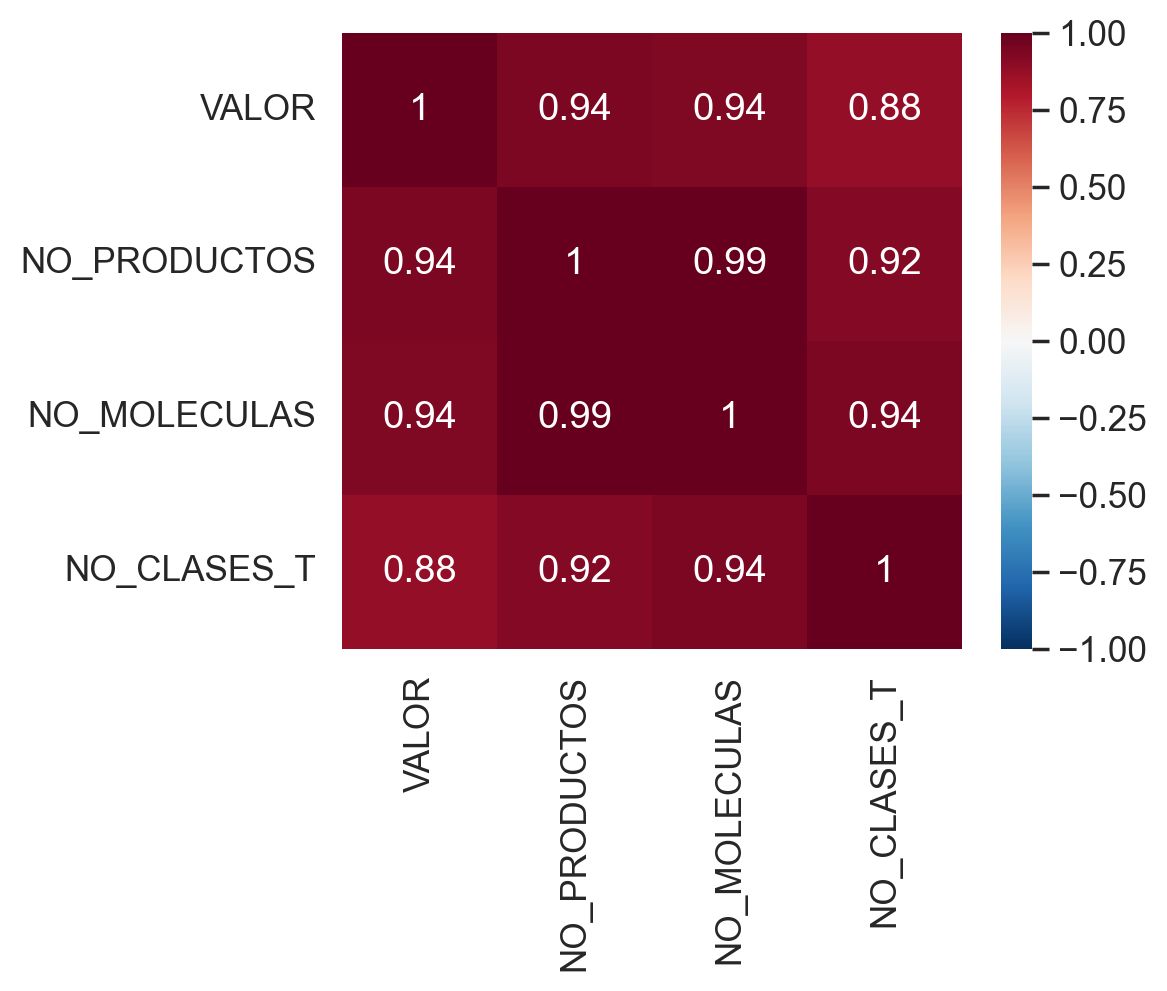

In [ ]:
# Crear el heatmap
sns.set(font_scale=1.15)
plt.figure(figsize=(5,4))
sns.heatmap(df_prescripciones[['VALOR', 'NO_PRODUCTOS', 'NO_MOLECULAS', 'NO_CLASES_T']].corr(),
            cmap='RdBu_r',
            annot=True,
            vmin=-1, vmax=1);

Las variables están fuertemente correlacionadas entre sí, lo que sugiere que todas ellas están relacionadas de manera significativa en el contexto del análisis. Esto puede implicar que un aumento en cualquiera de las variables tiende a estar acompañado por un aumento en las otras, sugiriendo una relación interdependiente entre el valor de los productos, el número de productos, el número de moléculas, y el número de clases terapéuticas.